In [284]:
#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import load_boston
from sklearn.utils.fixes import loguniform


In [2]:
data_dir='/home/ubuntu/cognition_iowa/data/'
results_dir='/home/ubuntu/cognition_iowa/results/' 

In [3]:
#Load input variables (estimated SC) and save all subjects to one .mat file for eFC prediction (Zijin's code)

nROIs=86
subj_id =  pd.read_csv(data_dir + 'final_subIDs.csv',header=None)[0]
sc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]
    
sio.savemat(data_dir + 'allstroke_SCs.mat', {'sc':sc}) # used to predict eFC using Zijin's code.


In [4]:
# Load demographic variables and outcome measures (TMT and WAIS)

#read in demographic info at first time point
demo =  pd.read_csv(data_dir + 'demographic_final.csv',header=0)

#read in cognitive scores at first time point
tmt = pd.read_csv(data_dir + 'T_MT_A_TIME.csv',header=None)
wais = pd.read_csv(data_dir + 'WAIS_IV_DS_TOTAL_RAW.csv',header=None)

In [253]:
# Set global training variables

#set the proportion of data you want in your training set
train_size = .8

#set the number of variables you want to predict
n_cog = 1

#set x data to be the input variable you want to use
#ie fc, sc, or hc
X = sc

# remove parameters that are 0 for all subjects
zeros=X==0
zeros=np.sum(zeros,0)
zeros=zeros==101
X=X[:,~zeros]

#set y to be the cognitive metrics you want to predict
Y = np.array(wais)

#set the number of features
n_feat = X.shape[0]

#create arrays to store variables
r2 = np.zeros([n_cog]) #r^2 - coefficient of determination
var = np.zeros([n_cog])#explained variance
corr = np.zeros([n_cog]) #correlation between true and predicted (aka prediction accuracy)
opt_alpha = np.zeros([n_cog]) #optimised alpha (hyperparameter)
preds = np.zeros([n_cog,int(np.ceil(X.shape[0]*(1-train_size)))]) #predictions made by the model
cogtest = np.zeros([n_cog,int(np.ceil(X.shape[0]*(1-train_size)))]) #true test values for cognition
featimp = np.zeros([n_feat, n_cog]) #feature importance extracted from the model

In [144]:

correl=[]
for i in range(0, x.shape[1]):
    correl.append(abs(spearmanr(x[:,i], y)[0]))
ind = np.argpartition(correl, -4)[-4:]
x[:,ind]

(101, 3201)


Permutation 4
Size of X: (80, 3201)
Size of y: (80, 1)
-0.028425708344910528
{'alpha': 1000.0}


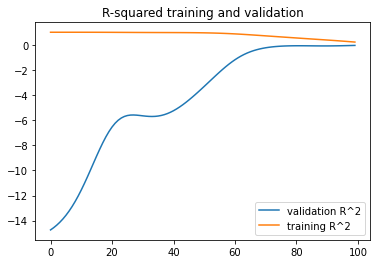

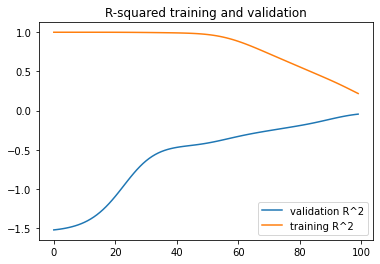

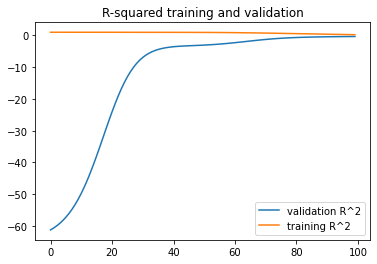

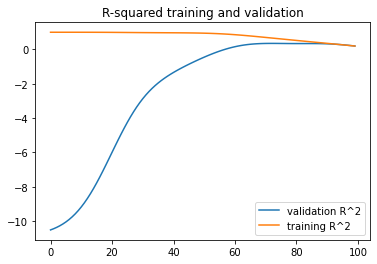

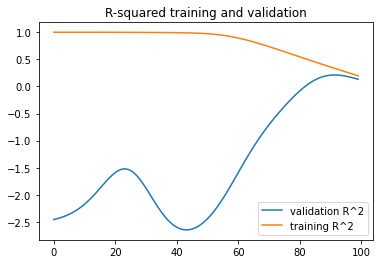

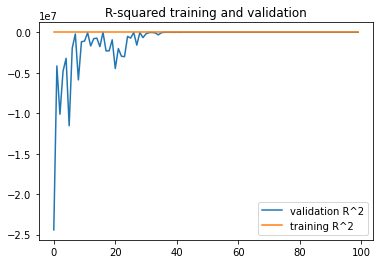

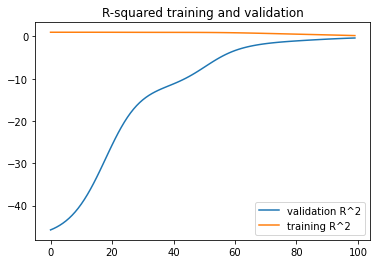

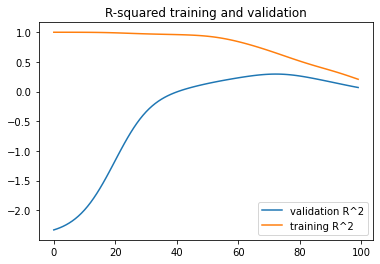

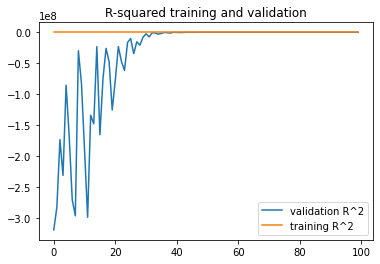

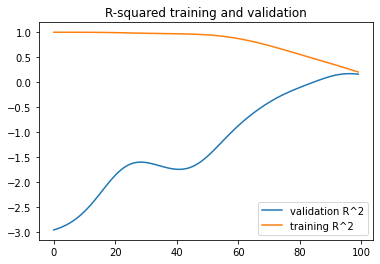

In [254]:
# Model selection & hyperparameter optimization
# We optimize alpha using only the training data (X_train, cog_train)
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764

#set hyperparameter grid space you want to search through for the model

p=3
n_cog=2
k=10

#joblib-based parallelism to increase speed
with parallel_backend('loky', n_jobs=16):

    #print permutation # you're on
    print('Permutation %d' %(p+1))
   # X = X[:, 1:50]
    #Splitting the dataset into a hold-out test set and training set for model selection.
    x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
    print("Size of X: " + str(x.shape))
    print("Size of y: " + str(y.shape))
    
    #Normalize training and test data using scaler fit to training data    
    scaler = preprocessing.StandardScaler().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)
    
    
    
    # scaler = preprocessing.StandardScaler().fit(x)
    #  x = scaler.transform(x)
    # x_holdout = scaler.transform(x_holdout)
    
    # Initializing Regression models
    regr1= linear_model.Ridge(normalize=True, max_iter=1000000)
    # Setting up cv object
    cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    #set hyperparameter grid space you want to search through for the model
    alphas = np.logspace(-4,3, num=100, endpoint=True,base=10, axis=0)
    paramGrid ={'alpha': alphas}    
    
    # regression scoring metrics
    scores = {"R-squared": "r2", "mse":'neg_mean_squared_error'}

    # Set up GridSearchCV object
    gcv = GridSearchCV(estimator=regr1,
                           param_grid=paramGrid,
                           scoring=scores,
                           n_jobs=16,
                           cv=cv,
                           return_train_score=True,
                           verbose=0,
                           refit="R-squared")

    # cross-validate
    gcv.fit(x, y) 
    
    results=pd.DataFrame.from_dict(gcv.cv_results_)
    results.to_csv(path_or_buf='/home/ubuntu/cognition_iowa/cvresults.csv', sep=',', header=True)

    
    
    print(gcv.best_score_)
    print(gcv.best_params_)
    
    #print(gcv.cv_results_)
    # plot the training curves    
    for i in range(0,k):
        fig,ax = plt.subplots()
        ax.plot(gcv.cv_results_['split'+str(i)+'_test_R-squared'], label='validation R^2')   
        ax.plot(gcv.cv_results_['split'+str(i)+'_train_R-squared'],label='training R^2') 
        #plt.ylim([-1, 1])
        plt.legend()
        #plt.xticks(np.logspace(-3,3, num=100, endpoint=True,base=10, axis=0))
        ax.set_title('R-squared training and validation')
    plt.savefig("/home/ubuntu/cognition_iowa/fig"+str(i+1)+".png")
        


In [282]:
len(correl)

3201

In [301]:
print(x.shape)

(80, 3201)


In [302]:

print(x.shape)

(80, 3201)


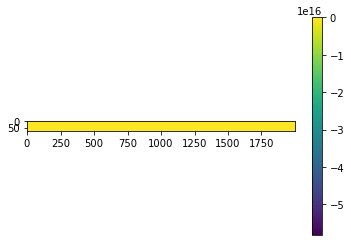

In [101]:
plt.imshow(x[1:100,1:2000])
plt.colorbar()
plt.show()

In [279]:
len(correl)

80

In [256]:
np.corr(x, y)

AttributeError: module 'numpy' has no attribute 'correlation'

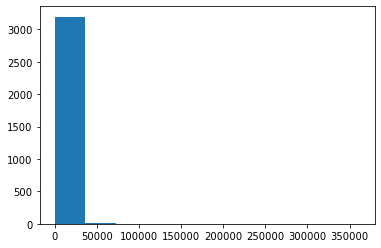

In [142]:
plt.hist(X[1,:])
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)


(array([3.195e+03, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([     0.  ,  36154.65,  72309.3 , 108463.95, 144618.6 , 180773.25,
        216927.9 , 253082.55, 289237.2 , 325391.85, 361546.5 ]),
 <BarContainer object of 10 artists>)

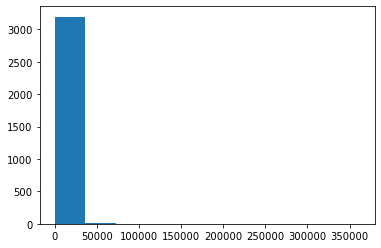

In [143]:
plt.hist(x[3,:])

In [87]:
np.savetxt(results_dir+'fc_demo_dmemfu1_r2.txt', r2, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_var.txt', var, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_corr.txt', corr, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_alpha.txt', opt_alpha, delimiter=',')

np.savetxt(results_dir+'fc_demo_dmemfu1_featimp.txt', featimp, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_preds.txt', preds, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_cogtest.txt', cogtest, delimiter=',')


In [88]:
A = np.zeros([perm,n_feat])

#iterate through permutations
for p in range(perm):
    print('Permutation %d' %(p+1))

    cov_x= np.zeros([n_feat])
    x_train, x_test, cog_train, cog_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)

    #compute covariance of training X data
    cov_x = np.cov(np.transpose(x_train))

    #for each of the cognitive scores
    for i in range(n_cog):
        #compute covariance of training cognitive scores
        cov_y = np.cov(cog_train[:,i])
        #compute activation vector by matrix multiplying training X covariance, feature weights, and 1/training Y covariance 
        A[p,:] = np.matmul(cov_x,featimp[p,:])*(1/cov_y)


A_avg = np.mean(A,axis=0)
np.savetxt(results_dir+'fc_demo_demo_dmemorig_featimpA_dmemfu1.txt', A_avg, delimiter=',')

Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permutation 67
Perm